## Explaining How a Deep Neural Network Trained with End-to-End Learning Steers a Car

References:
* https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/
* http://www.nvidia.com/object/drive-px.html
* https://arxiv.org/pdf/1604.07316.pdf
* https://arxiv.org/pdf/1704.07911v1.pdf
* https://www.youtube.com/watch?v=2TT1EKPV_hc
* http://stackoverflow.com/questions/34975972/how-can-i-make-a-video-from-array-of-images-in-matplotlib
* http://stackoverflow.com/questions/4092927/generating-movie-from-python-without-saving-individual-frames-to-files
* https://www.reddit.com/r/IPython/comments/35tocn/is_it_possible_to_embed_a_local_file_video_in_the/

In [1]:
import tensorflow as tf
import scipy.misc
import sys
sys.path.append('../')
import model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as plt_anim
from PIL import Image
import random
import os
import subprocess
import glob


folder_dataset = "../Track3_Wheel/"
IMGS_OUT_FOLDER = '../imgs_salient'

### Open Model

In [2]:
# Load tensorflow section
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "../save/model-66")

### Read a folder and load to memory

In [3]:
# Lists to hold image filename and label
xs = []
ys = []

with open(folder_dataset + "data.txt") as f:
    for line in f:
        # Image path
        xs.append(folder_dataset + line.split()[0])        
        # Steering wheel label
        ys.append(np.float32(line.split()[1]))

num_images = len(xs)
print("Number of images: %d" % num_images)

# Use zip to create a list with images/labels
c = list(zip(xs, ys))
#random.shuffle(c)
xs, ys = list(zip(*c))

# Load list to memory
list_imgs = []
for imPath in xs:
    image = scipy.misc.imread(imPath, mode="RGB")
    list_imgs.append(image)

# Just print to debug
print(list_imgs[0].shape)

Number of images: 2160
(256, 256, 3)


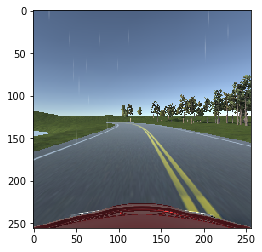

Wheel angle: -0.0413943


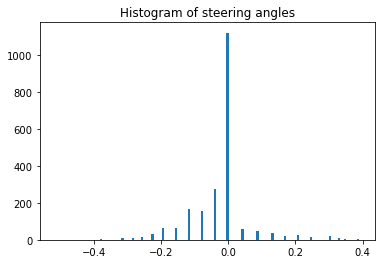

In [4]:
rand_index = random.randint(0,len(list_imgs)-1)
plt.imshow(list_imgs[rand_index])
plt.show()
print('Wheel angle:', ys[rand_index])
plt.hist(ys,bins='auto')
plt.title("Histogram of steering angles")
plt.show()

### Evalulate network to get one steering angle

In [5]:
idx_img = 0
list_imgs_act = []
for (tup_element) in list(zip(list_imgs, ys)):
        img,steer = tup_element
        image = scipy.misc.imresize(img[-130:], [66, 200]) / 255.0
        degrees = model.y.eval(feed_dict={model.x: [image], model.dropout_prob: 1.0})[0][0]
        #print('Steering angle for this image:',degrees)
        
        # Grab activations
        conv5act, conv4act, conv3act, conv2act, conv1act = sess.run(
            [model.conv5, model.conv4, model.conv3, model.conv2, model.conv1], 
            feed_dict={model.x: [image], model.dropout_prob: 1.0})
        
        # Get the mean and supress the "batch" dimension
        averageC5 = np.mean(conv5act,axis=3).squeeze(axis=0)
        averageC4 = np.mean(conv4act,axis=3).squeeze(axis=0)
        averageC3 = np.mean(conv3act,axis=3).squeeze(axis=0)
        averageC2 = np.mean(conv2act,axis=3).squeeze(axis=0)
        averageC1 = np.mean(conv1act,axis=3).squeeze(axis=0)
        
        # This could be implented with a transpose convolution on the graph
        averageC5up = scipy.misc.imresize(averageC5,[averageC4.shape[0], averageC4.shape[1]])

        multC45 = np.multiply(averageC5up,averageC4)        
        multC45up = scipy.misc.imresize(multC45,[averageC3.shape[0], averageC3.shape[1]])        
        multC34 = np.multiply(multC45up,averageC3)        
        multC34up = scipy.misc.imresize(multC34,[averageC2.shape[0], averageC2.shape[1]])        
        multC23 = np.multiply(multC34up,averageC2)        
        multC23up = scipy.misc.imresize(multC23,[averageC1.shape[0], averageC1.shape[1]])        
        multC12 = np.multiply(multC23up,averageC1)        
        multC12up = scipy.misc.imresize(multC12,[image.shape[0], image.shape[1]])
        
        # Normalize activation
        salient_mask = (multC12up - np.min(multC12up))/(np.max(multC12up) - np.min(multC12up))
        
        list_imgs_act.append(salient_mask)
        
        # Save each result as an image
        #plt.imsave('imgs_salient/salient_' + str(idx_img) + '.png',salient_mask)
        #idx_img += 1        
        

In [6]:
def generate_video(image_list, folder, video_name):
    curr_folder = os.getcwd()
    idx_img = 0
    for img in image_list:        
        plt.imsave(folder + '/salient_' + str(idx_img) + '.png',img)  
        idx_img += 1

    os.chdir(folder)
    subprocess.call([
        'ffmpeg', '-framerate', '8', '-i', 'salient_%d.png', '-r', '30', '-pix_fmt', 'yuv420p',
        video_name
    ])
    for file_name in glob.glob("*.png"):
        os.remove(file_name)
    
    # Go back to previous directory
    os.chdir(curr_folder)

In [7]:
generate_video(list_imgs_act, IMGS_OUT_FOLDER, 'video_salient.mp4')
generate_video(list_imgs, IMGS_OUT_FOLDER, 'video_original.mp4')

### Show mask over the image

In [10]:
%%html
<!-- TODO -->
<iframe width="256" height="256" controls src="../imgs_salient/video_salient.mp4" allowfullscreen></iframe>

In [11]:
%%html
<!-- TODO -->
<iframe width="256" height="256" controls src="../imgs_salient/video_original.mp4" allowfullscreen></iframe>